In [1]:
# load packages
import pyproj,os,rioxarray
import xesmf as xe
import xarray as xr
import numpy as np
from netCDF4 import Dataset
import pandas as pd
import cartopy.crs as crs
from wrf import (getvar, interplevel, vertcross, 
                 CoordPair, ALL_TIMES, to_np,
                 get_cartopy, latlon_coords,
                 cartopy_xlim, cartopy_ylim,
                 Constants,extract_vars)
from matplotlib import pyplot as plt
# Define global setting
xr.set_options(keep_attrs=True)

In [2]:
# Build curvilinear grids for netcdfs
def build_wrf_gird(WRF_d,geo_file):
    """
    Function: build x,y curvilinear grids from WRF input dataset and geo_em
    Input: path for WRF dataset, path for geo_em file
    Output: WRF netcdf with curvilinear grid in lat/lon, coordinate system for WRF24
    """
    # Open geo_em file, get HGT var, cart_proj and lats and lons
    geo=Dataset(geo_file)
    HGT = getvar(geo,"HGT_M",timeidx=ALL_TIMES)
    WRF_cart_proj = get_cartopy(HGT)
    WRF_lats, WRF_lons = latlon_coords(HGT)
    # Create WRF Projection
    wrf_globe = crs.Globe(ellipse=None,
                          semimajor_axis=Constants.WRF_EARTH_RADIUS,
                          semiminor_axis=Constants.WRF_EARTH_RADIUS)
    # Define a latitude/longitude coordinate system
    wrf_xform_crs = crs.Geodetic(globe=wrf_globe)
    # Open dataset
    if '_mon_' in WRF_d: 
        WRF=xr.open_dataset(WRF_d,decode_times=False,chunks={'month':12})
    elif '_sea_' in WRF_d:
        WRF=xr.open_dataset(WRF_d,decode_times=False,chunks={'season':4})
    
    # Insert lat and lon for re-gridding
    WRF_latlon=WRF.assign_coords({'lat':(('south_north','west_east'),WRF_lats.values),'lon':(('south_north','west_east'),WRF_lons.values)})
    # Drop coordinate XTIME
    WRF_latlon=WRF_latlon.drop_vars(['XTIME'])
    return WRF_latlon,WRF_cart_proj, wrf_xform_crs

In [3]:
# Interpolate to WRF24 grids
def to_WRF_grid(WRF,WRF_proj,WRF_crs,obs_d=None):
    """
    Function: Interpolate input dataset to WRF24 grid and perform remapping 
    Input: WRF xarray dataset with lat and lon,WRF porjection, WRF coordinate system, 
           Observation dataset
           remap from polar to WRF24 for i.ie. Rutgers Northern Hemisphere 24 km Weekly Snow Cover Extent
           or from WGS1984 to WRF24 for i.e. ERA5 Land
    Output: netcdf with curvilinear grid in EPSG 4326
    """
    # Grab ending year of WRF dataset
    year_end=int(WRF.attrs['end_date'][0:4])+1
    # For WRF output
    if obs_d==None:
        # Generate lat long based on WRF Projection
        xform_pts = WRF_proj.transform_points(WRF_crs,to_np(WRF.lon),to_np(WRF.lat))
        WRF_x = xform_pts[...,0]
        WRF_y = xform_pts[...,1]
        # insert lat and lon grids into dataset         
        WRF_output=WRF.assign_coords({'lat':(('south_north','west_east'),WRF_y),'lon':(('south_north','west_east'),WRF_x)})
        return WRF_output
    else:
    # Open dataset
    # For rutger dataset
        if 'rutgers' in obs_d:
            obs_raw=xr.open_dataset(obs_d,chunks={'time':100})
    # For ERA5-Land dataset
        elif 'era5l' in obs_d:
            obs_raw=xr.open_mfdataset(obs_d)
            # Rechunk dataset
            obs_raw=obs_raw.chunk({'time':200,'latitude':200,'longitude':500})
        # Generate normal for dataset
        if 'month' in WRF.coords:
            obs_norm=obs_raw.isel(time=(obs_raw.time.dt.year<year_end)).groupby('time.month').mean('time')
        if 'season' in WRF.coords:
            obs_norm=obs_raw.isel(time=(obs_raw.time.dt.year<year_end)).groupby('time.season').mean('time')
        # Rename lat/lon
        obs_output=obs_norm.rename({'latitude':'lat','longitude':'lon'})
        # Mask missing value for Rutger dataset
        if 'rutgers' in obs_d:
            # Extract lat/lon as 2d numpy arrays
            obs_lat=obs_output.lat.values
            obs_lon=obs_output.lon.values.T
            # Replace missing values with nan
            new_lat=np.where(obs_lat>90,np.nan,obs_lat)
            new_lon=np.where(obs_lon>180,np.nan,obs_lon)
            obs_output=obs_output.assign_coords({'lat':(('x','y'),new_lat),'lon':(('x','y'),new_lon)})
        # Regrid to WRF24
        Regridder=xe.Regridder(obs_output,WRF,'patch')
        print('Regridding start')
        obs_output_re=Regridder(obs_output)
        # Transform to WRF Projection
        xform_pts = WRF_proj.transform_points(WRF_crs,to_np(obs_output_re.lon.values),to_np(obs_output_re.lat.values))
        obs_wrf_x = xform_pts[...,0]
        obs_wrf_y = xform_pts[...,1]
        obs_output_re=obs_output_re.assign_coords({'lat':(('south_north','west_east'),obs_wrf_y),
                                                        'lon':(('south_north','west_east',),obs_wrf_x)})
        return obs_output_re

In [11]:
WRF_conus='/project/p/peltier/edmundn/climate_normals_Py/MPIESM12HR/conus43-flk_na24/wrflsm_HS_sea_norm_1979-2014.nc'
WRF_new='/project/p/peltier/edmundn/climate_normals_Py/MPIESM12HR/new43-flk_na24/wrflsm_HS_sea_norm_1979-2014.nc'
WRF_newloc='/project/p/peltier/edmundn/climate_normals_Py/MPIESM12HR/new43loc-flk_na24/wrflsm_HS_sea_norm_1979-2014.nc'
Polar='/project/a/aerler/Data/Rutgers/rutgers_monthly/original/rutgers_monthly.nc'
geo='/scratch/p/peltier/mahdinia/wrf/MPIESM12HR_HS_na24_conus43-flk_1979/geo_em.d01.nc'
era5='/project/a/aerler/Data/ERA5/era5l_monthly/original/*.nc'

In [12]:
conus=build_wrf_gird(WRF_conus,geo)
conus_re=to_WRF_grid(conus[0],conus[1],conus[2])
new=build_wrf_gird(WRF_new,geo)
new_re=to_WRF_grid(new[0],new[1],new[2])
newloc=build_wrf_gird(WRF_newloc,geo)
newloc_re=to_WRF_grid(newloc[0],newloc[1],newloc[2])

In [ ]:
polar_re=to_WRF_grid(a[0],a[1],a[2],obs_d=Polar)

/home/p/peltier/edmundn/miniconda3/envs/ccia_wrf/lib/python3.11/site-packages/xesmf/backend.py:41: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


In [ ]:
era5l_re=to_WRF_grid(a[0],a[1],a[2],obs_d=era5)

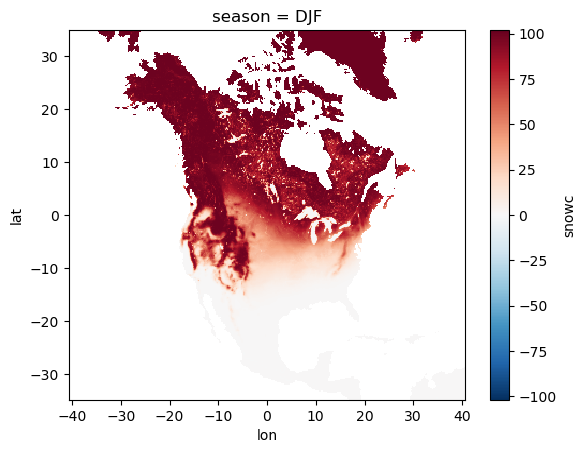